# This is a notebook for Solving PDEs as Petri Nets with PyCIEMSS

### Load dependencies

In [1]:
import os
import pyciemss
import pandas as pd

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

smoke_test = ('CI' in os.environ)

### Set simulation parameters

In [2]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_timepoints = int((end_time - start_time - 1) // logging_step_size)
num_samples = 3 if smoke_test else 10

### Load models from [DARPA-ASKEM/Model-Representations](https://github.com/DARPA-ASKEM/Model-Representations/tree/pde-petri-amrs/petrinet/examples/pde/advection)

In [3]:
# MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/pde-petri-amrs/petrinet/examples/pde/advection/"
MODEL_PATH = "../../docs/source/"

advection1D1 = os.path.join(MODEL_PATH, "advection_backward_1_0.01_3.json")
advection1D2 = os.path.join(MODEL_PATH, "advection_backward_1_0.01_5.json")
advection1D3 = os.path.join(MODEL_PATH, "advection_backward_1_0.01_10.json")

## 1-D Advection Equation
$$\frac{\partial a}{\partial t} = -u\frac{\partial a}{\partial x}, x \in [-1.5, 1.5]$$ 

In [4]:
result = pyciemss.sample(advection1D1, end_time, logging_step_size, num_samples, start_time=start_time)
result["data"].head()

,timepoint_id,sample_id,persistent_dx_param,persistent_u_param,a_0_state,a_1_state,a_2_state
0,0,0,0.079697,0.451424,-0.017343,-0.017031,-0.016720
1,1,0,0.079697,0.451424,-0.034998,-0.034686,-0.034374
2,2,0,0.079697,0.451424,-0.052652,-0.052340,-0.052029
3,3,0,0.079697,0.451424,-0.070307,-0.069995,-0.069683
4,4,0,0.079697,0.451424,-0.087961,-0.087650,-0.087338


### Extract model states and x-coordinates

In [5]:
import json

with open(advection1D1, 'r') as json_file:
    data = json.load(json_file)
    
state_data = data['model']['states']

# Extracting states and x-coordinates from model
state_names = [item['id'] for item in state_data]
state_names = [state + '_state' for state in state_names]
x_coords = [float(item['description'].split('[', 1)[1].split(']', 1)[0]) for item in state_data]

print("State names:", state_names)
print("X-coordinates:", x_coords)
x_state_dict = {x: state for x, state in zip(x_coords, state_names)}

State names: ['a_0_state', 'a_1_state', 'a_2_state']
X-coordinates: [-1.5, 0.0, 1.5]


### Reconfigure the `results` DataFrame for plotting

In [6]:
# For each timepoint, extract the corresponding solution across all states in the domain
x_values = []
all_y_values = []
sid = []
for i in range(num_timepoints):
    y_values = []
    df = result["data"][result["data"]["timepoint_id"] == i]
    # Extract states corresponding to each timepoint
    for sample_id in df['sample_id']:
        for x, column in x_state_dict.items():
            y_values.append(df.loc[df['sample_id'] == sample_id, column].values[0])
            x_values.append(x)
            sid.append(sample_id)
    all_y_values.append(y_values)
    
# Move these into a DataFrame where labels are what is expected by plot
timepoint_id = x_values[0:len(all_y_values[0])]
sample_id = sid[0:len(all_y_values[0])]
for i, sublist in enumerate(all_y_values, start=0):
    globals()[f"t{i}_state"] = sublist
    
data = {
    'timepoint_id': timepoint_id,
    'sample_id': sample_id
}
for i, sublist in enumerate(all_y_values, start=0):
    data[f"t{i}_state"] = sublist

df = pd.DataFrame(data)

### Plot the results

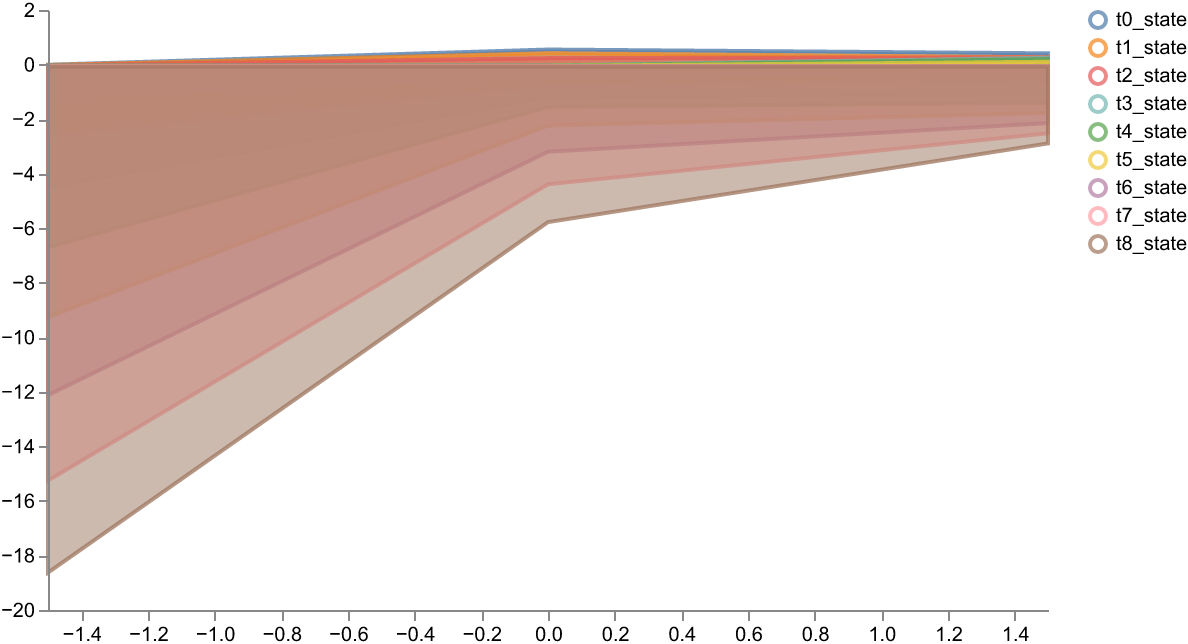

In [7]:
# Plot results for all states
schema = plots.trajectories(df, keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)